In [13]:
import random
from helpers import *
# random.seed(6)
# np.random.seed(6)
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')

# redefine Z to be all the other columns except the last one
n,p= Z.shape
Znorm = normalize_columns(Z)
mu0 = np.mean(Znorm, axis=0)
Sigma0 = np.cov(Znorm.T)
#Gamma0 = np.zeros((p, p))
Gamma0 =np.random.normal(0.0001,0.001,(p,p))
#find best sr
# St = sr_best(Znorm,lambda_val = 0.01, sigma = 500, T = 10000)
# print(St)
St=np.array([ 0, 4, 6, 9, 22])
Z0 = Z[:,St]
Gamma0[St] = np.linalg.inv(Z0.T@Z0)@Z0.T@Z

Gamma = cp.Variable((p,p))
Gamma.value = Gamma0
############ Sigma 1 ###################
Sigma = np.cov((Z-Z@Gamma.value).T)
############ Sigma 2 ###################
# Sigma = (Z-Z@Gamma0).T@(Z-Z@Gamma0)/n
############ Sigma 3 ###################
# k=5
# U, S, V =  np.linalg.svd(Z)
# Z_approx = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
# # Calculate the difference between the rank-k approximation and the actual values
# difference = Z - Z_approx
# Sigma = np.cov(np.transpose(difference), rowvar=True)  
# Sigma_inverse = np.linalg.inv(covariance_matrix) / 10**17

S,U=np.linalg.eig(Sigma)
Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T/ 10**13

for i in range(1):
    objective = cp.Minimize(cp.norm( Sigma_half_inv @ Z.T - Sigma_half_inv @ Gamma.T @ Z.T  , 'fro')**2)
    # Define the constraint
    constraints = [
        cp.sum(cp.norm(Gamma, 2, axis=1))<=5
    ]
    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    # Solve the optimization problem
    result = problem.solve()

St0= chosen_set_with_press(Gamma.value,5,Znorm)[0]
print(np.linalg.norm(Gamma.value, axis=1))
print(St0,'sr',sr(np.linalg.solve(Sigma0[St0][:, St0], mu0[St0]), mu0[St0], Sigma0[St0][:, St0]) )


[8.74469887e-05 1.45996978e-05 2.33585915e-05 1.56420666e-05
 4.01194894e-05 5.61678507e-05 1.66474207e-05 7.15353929e-08
 1.61434127e-05 1.27314027e-04 8.16909296e-06 2.34963023e-05
 1.70911911e-05 1.32638001e-05 6.09953854e-06 1.55389300e-05
 2.05690640e-06 1.44902626e-05 7.71637947e-06 1.55911962e-05
 5.36333600e-06 1.10601985e-05 6.74591805e-05 1.06074225e-05
 5.29169198e-06]
[9, 0, 22, 5, 4] sr 0.10560294716641169


In [2]:

import numpy as np

import pandas as pd
import warnings

from helpers import *

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]
df22 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X22_22.csv')
dff22 = df22[df22.columns[1:]]
df99['Unnamed: 0'] = fama285_['Date']
df22['Unnamed: 0'] = fama285_['Date']

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
opt Index(['EPRD', 'ME', 'HMLM', 'REG', 'IVOL', 'PEAD'], dtype='object')
sr 0.4838745541756356


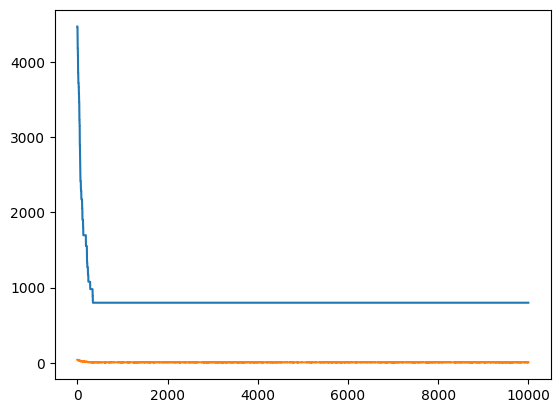

In [59]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =10000
sigma =100
lambd =100
k = 9#or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)


Sigma_inv = np.linalg.inv(Sigma)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(
        -sigma * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd * len(S_new)
        +sigma * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd * len(St)
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * Theta[0] @ Sigma_inv @Theta[0].T + lambd * len(St)
    if SRwPenalty[t]<0:
        print(SRwPenalty[t], Theta[0] @ Sigma_inv @Theta[0].T )
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 78, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 70, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 

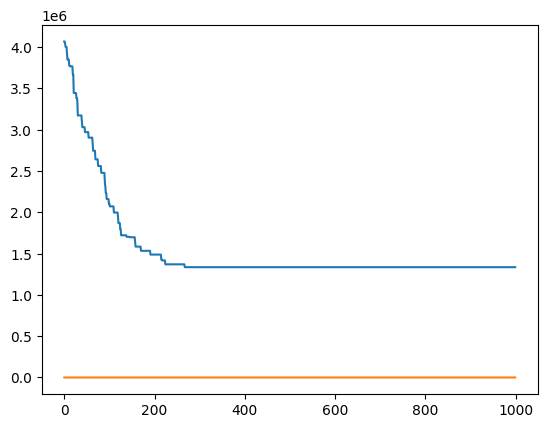

In [67]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =1000
sigma = 0.6
lambd1 =40000
lambd2 =80000
k = 9 # or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(-sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        +sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
        
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
   
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

opt Index(['OCP', 'MKTRF', 'REG', 'IVOL', 'IA', 'BETA'], dtype='object')
sr 0.3616306746904429
objective 4504955.672131507
aSa 1134432.2469466855
RSS 970523.4251848223


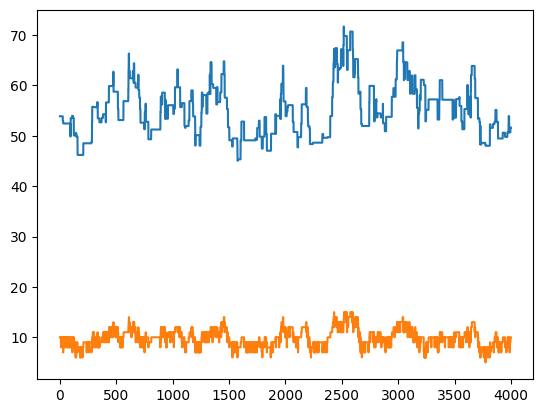

In [3]:
from helpers import  *
import numpy as np

import pandas as pd
import warnings


warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
T = 5000
sigma =0.00001
lambd1 =2/sigma
k = 9
lambd2 = 4/sigma

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:30]
#print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
Objective = np.zeros(T)
aSa = np.zeros(T)
RSS = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(sigma * (-np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        + np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
    ))
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        #print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    Objective[t] =  np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
    aSa[t] = Theta[0]@ Sigma_inv @Theta[0].T
    RSS[t] = np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
import matplotlib.pyplot as plt
#Plots
plt.plot(Objective[1000:]/100000)
plt.plot(np.sum(Sseq[:,1000:], axis=0))    
sridx = np.argmin(Objective)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))
print('objective', Objective[sridx])
print('aSa', lambd1*aSa[sridx])
print('RSS', RSS[sridx])

In [11]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta@Sigma_half_inv,axis=1))

5235.3514613311745

In [ ]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta,axis=1))

19.716747709665434

# Optimize Theta

In [13]:
############# Optimize Theta ################
from helpers import  *
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =10
k = 9
lambd = 2/0.00001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
e1 = (np.eye(p+1)[0][:,np.newaxis])

# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Z1 = np.concatenate((np.ones((n,1)),Z[:,:]),axis=1)

######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.MOSEK, warm_start = True)



In [2]:

chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[88, 89, 90, 91, 92, 93] ['LTR' 'REG' 'IVOL' 'SUE' 'IA' 'ROE']
sr 0.31175882415678985


# try small set in X_s

In [4]:
############change small
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =2/0.001
k = 9
lambd = 2/0.001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)

# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Sopt0 =[]
for i in ['ILR1', 'CMA', 'STR', 'REG', 'IVOL', 'PEAD','OCP', 'MKTRF', 'IA','BETA','CLA']:
    Sopt0.append(list(dff99.columns).index(i))
Sopt0+=[0,1,2,3,4,5,6,7,8,9,10]
Sopt = Sopt0
Z1 = np.concatenate((np.ones((n,1)),Z[:,Sopt]),axis=1)
e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
Gamma = cp.Variable((len(Sopt)+1,p))
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.MOSEK, warm_start = True)


In [5]:
# chosen_set=chosen_set_with_press((B.value @ Sigma_half_inv)[1:],6,Z)[0]
chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z[:,Sopt])[0]
print(chosen_set,np.array(dff99.columns)[np.array(Sopt)[chosen_set]])

mu = np.mean(Z[:,Sopt], axis=0)
Sigma = np.cov(Z[:,Sopt].T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[7, 17, 16, 4, 1, 8] ['MKTRF' 'COP' 'CLA' 'IVOL' 'CMA' 'IA']
sr 0.169846323609881


# Optimize B



In [23]:
#B
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C=1000
k = 9
lambd = 2/0.001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half = U@np.diag(np.sqrt(S))@U.T
Sigma_half_inv =np.linalg.inv(Sigma_half)

Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 = np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
B = cp.Variable((p+1,p))
# B.value =  Gamma0 @ Sigma_half
Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
e1 = (np.eye(p+1)[0][:,np.newaxis])
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @ B, 'fro')**2 )
# Define the constraint
# constraints = [
#     cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C
# ]

constraints = [
    cp.sum(cp.norm((B )[1:] , 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.MOSEK)


In [29]:
#B
chosen_set=chosen_set_with_press((B.value @ Sigma_half)[1:],12,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[27, 98, 46, 68, 8, 79, 84, 55, 3, 81, 7, 69] ['EBP' 'FIN' 'IVq1' 'ROA1' 'CP' 'HML' 'QMJ' 'OCP' 'BM' 'CMA' 'COP' 'ROE1']
sr 0.10328564415253157


In [28]:
np.round(np.linalg.norm(B.value,axis=1),3)

array([1.62000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.85110e+01,
       0.00000e+00, 0.00000e+00, 1.00000e-03, 2.30450e+01, 9.29070e+01,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 1.80953e+02, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 1.00000e-03, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 1.64959e+02, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 4.54800e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.00000e-03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.333

In [25]:
B.value@Sigma_half_inv

array([[ 1.75906352e+01, -1.03004823e+00, -2.65065020e+01, ...,
         7.68402640e+01,  2.10793640e+01,  9.53208586e+01],
       [ 3.44941287e-04, -1.65991910e-05,  1.41491025e-04, ...,
         4.56802581e-04,  3.67539741e-04,  1.14219360e-04],
       [ 2.28813750e-05,  1.22621199e-04,  4.44587153e-05, ...,
        -1.56592370e-04,  3.62249082e-05, -1.11153546e-04],
       ...,
       [ 5.22124667e-03, -5.88517678e-03, -1.75995343e-02, ...,
         4.31707202e-02,  4.57232659e-03,  4.36585690e-02],
       [ 3.98997100e-04, -1.69404385e-05,  2.45900572e-04, ...,
         5.19847429e-04,  4.92088782e-04,  7.20230947e-05],
       [ 2.75951352e+02, -1.15088744e+03, -5.87653282e+03, ...,
         9.88088202e+03, -4.58105039e+01,  1.26366668e+04]])

In [ ]:
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma0